In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from pprint import pprint
pd.set_option('display.max_columns', 70)

from IPython.core.display import HTML
from IPython.display import display

In [2]:
df = pd.read_csv("./WA_UseCase_HRAttrition_data.csv", delimiter=';')
num_obs, num_features = df.shape
print "Number Observations={0}, Num Features={1}".format(num_obs, num_features)
df.head()

Number Observations=1470, Num Features=36


,Age,AgeWhenHired,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,49,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,4,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,25,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,4,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,35,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,5,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,34,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,5,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,36,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,5,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [3]:
# determine if there are any missing values for each of the columns
import collections
c = collections.Counter()
for col in df.columns.values: c[col] += df[df[col].isnull()].shape[0]
from pprint import pformat
pprint(c)

Counter({'PercentSalaryHike': 0, 'RelationshipSatisfaction': 0, 'YearsSinceLastPromotion': 0, 'EnvironmentSatisfaction': 0, 'MonthlyRate': 0, 'Over18': 0, 'Department': 0, 'JobLevel': 0, 'TotalWorkingYears': 0, 'JobInvolvement': 0, 'MaritalStatus': 0, 'StandardHours': 0, 'PerformanceRating': 0, 'StockOptionLevel': 0, 'AgeWhenHired': 0, 'DailyRate': 0, 'Gender': 0, 'Age': 0, 'YearsWithCurrManager': 0, 'WorkLifeBalance': 0, 'BusinessTravel': 0, 'JobSatisfaction': 0, 'HourlyRate': 0, 'EducationField': 0, 'JobRole': 0, 'NumCompaniesWorked': 0, 'YearsInCurrentRole': 0, 'YearsAtCompany': 0, 'TrainingTimesLastYear': 0, 'MonthlyIncome': 0, 'OverTime': 0, 'DistanceFromHome': 0, 'EmployeeNumber': 0, 'EmployeeCount': 0, 'Attrition': 0, 'Education': 0})


In [4]:
# map categorical binary mappings
# Attrition = Gradual Reduction in workforce (If High Attrition: Need to replace employees as they are leaving)
# Age, Over18 = There are no people below 18 (workforce)
# Gender -> Gender_IsMale
attrition_map = {'No':0, 'Yes': 1}
gender_map    = {'Male': 1, 'Female': 0}
overtime_map  = {'No': 0, 'Yes': 1} 
over18_map    = {'Y': 1}  

df.Attrition = df.Attrition.apply(lambda x: attrition_map[x])
df.Gender    = df.Gender.apply(lambda x: gender_map[x])
df.OverTime  = df.OverTime.apply(lambda x: overtime_map[x])
df.Over18    = df.Over18.apply(lambda x: over18_map[x])

In [5]:
# review counts of binary types
def field_stats(df_in, field, obs_cnt):
    field_cnt = df_in[df_in[field] == 1].shape[0]
    negate_field_cnt = obs_cnt - field_cnt
    pct_field = (field_cnt/float(obs_cnt)) * 100
    return 'Field:{0}\tExistent:{1}\tRemaining:{2}\tPct:{3}'.format(field, field_cnt, negate_field_cnt, pct_field)

print field_stats(df, "Attrition", num_obs)
print field_stats(df, "Gender", num_obs)
print field_stats(df, "OverTime", num_obs)
print field_stats(df, "Over18", num_obs)

Field:Attrition	Existent:237	Remaining:1233	Pct:16.1224489796
Field:Gender	Existent:882	Remaining:588	Pct:60.0
Field:OverTime	Existent:416	Remaining:1054	Pct:28.2993197279
Field:Over18	Existent:1470	Remaining:0	Pct:100.0


In [6]:
# what can we say about Age and work role period for those leaving
df_subset_yrs = df[['Attrition', 'Age', 'AgeWhenHired', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 
                    'YearsSinceLastPromotion', 'YearsWithCurrManager']]

display( df_subset_yrs[df_subset_yrs.Attrition == 1].describe() )
display( df_subset_yrs[df_subset_yrs.Attrition == 0].describe() )

,Attrition,Age,AgeWhenHired,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,237.0,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000
mean,1.0,33.607595,35.257384,8.244726,5.130802,2.902954,1.945148,2.852321
std,0.0,9.689350,9.254706,7.169204,5.949984,3.174827,3.153077,3.143349
min,1.0,18.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,28.000000,28.000000,3.000000,1.000000,0.000000,0.000000,0.000000
50%,1.0,32.000000,36.000000,7.000000,3.000000,2.000000,1.000000,2.000000
75%,1.0,39.000000,43.000000,10.000000,7.000000,4.000000,2.000000,5.000000
max,1.0,58.000000,50.000000,40.000000,40.000000,15.000000,15.000000,14.000000


,Attrition,Age,AgeWhenHired,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1233.0,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000
mean,0.0,37.561233,34.137064,11.862936,7.369019,4.484185,2.234388,4.367397
std,0.0,8.888360,9.074092,7.760719,6.096298,3.649402,3.234762,3.594116
min,0.0,18.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,31.000000,26.000000,6.000000,3.000000,2.000000,0.000000,2.000000
50%,0.0,36.000000,34.000000,10.000000,6.000000,3.000000,1.000000,3.000000
75%,0.0,43.000000,42.000000,16.000000,10.000000,7.000000,3.000000,7.000000
max,0.0,60.000000,50.000000,38.000000,37.000000,18.000000,15.000000,17.000000


In [7]:
# What can we say about Salary Rates for those leaving
df_salaries = df[['Attrition', 'DailyRate', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'OverTime']]
display( df_salaries[df_salaries.Attrition == 1].describe() )
display( df_salaries[df_salaries.Attrition == 0].describe() )

,Attrition,DailyRate,HourlyRate,MonthlyIncome,MonthlyRate,OverTime
count,237.0,237.000000,237.000000,237.000000,237.000000,237.000000
mean,1.0,750.362869,65.573840,4787.092827,14559.308017,0.535865
std,0.0,401.899519,20.099958,3640.210367,7208.153264,0.499768
min,1.0,103.000000,31.000000,1009.000000,2326.000000,0.000000
25%,1.0,408.000000,50.000000,2373.000000,8870.000000,0.000000
50%,1.0,699.000000,66.000000,3202.000000,14618.000000,1.000000
75%,1.0,1092.000000,84.000000,5916.000000,21081.000000,1.000000
max,1.0,1496.000000,100.000000,19859.000000,26999.000000,1.000000


,Attrition,DailyRate,HourlyRate,MonthlyIncome,MonthlyRate,OverTime
count,1233.0,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000
mean,0.0,812.504461,65.952149,6832.739659,14265.779400,0.234388
std,0.0,403.208379,20.380754,4818.208001,7102.260749,0.423787
min,0.0,102.000000,30.000000,1051.000000,2094.000000,0.000000
25%,0.0,477.000000,48.000000,3211.000000,7973.000000,0.000000
50%,0.0,817.000000,66.000000,5204.000000,14120.000000,0.000000
75%,0.0,1176.000000,83.000000,8834.000000,20364.000000,0.000000
max,0.0,1499.000000,100.000000,19999.000000,26997.000000,1.000000


In [8]:
# convert those remaining as multivalued dummies
df_objcols = df.loc[:, df.dtypes == object].columns.values
df_dummies = pd.get_dummies( df.loc[:, df.dtypes == object] )
df_comb = pd.concat([df_dummies, df], axis=1)
df_comb = df_comb.drop(df_objcols, axis=1)

In [9]:
# Other Notable Features
# EmplyeeNumber: 1
# EnvironmentSatisfaction, JobInvolvement, JobSatisfaction: 1-4
# JobLevel: 1-5
df.describe()

,Age,AgeWhenHired,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,34.317687,0.161224,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,0.600000,65.891156,2.729932,3.936054,2.728571,6502.931293,14313.103401,2.693197,1.0,0.282993,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,9.109598,0.367863,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,0.490065,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,0.0,0.450606,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,19.000000,0.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,1.0,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,27.000000,0.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,0.000000,48.000000,2.000000,3.000000,2.000000,2911.000000,8047.000000,1.000000,1.0,0.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,34.000000,0.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,1.000000,66.000000,3.000000,4.000000,3.000000,4919.000000,14235.500000,2.000000,1.0,0.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,42.000000,0.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,1.000000,83.750000,3.000000,5.000000,4.000000,8379.000000,20461.500000,4.000000,1.0,1.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,50.000000,1.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,1.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,1.0,1.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [10]:
# dipslay the skew
display( pd.DataFrame(df.skew().sort_values(ascending=False)).T )
# display the correlation
display( pd.DataFrame( df_comb.corr()['Attrition'].sort_values(ascending=False)).T )

,YearsSinceLastPromotion,PerformanceRating,Attrition,YearsAtCompany,MonthlyIncome,TotalWorkingYears,NumCompaniesWorked,StockOptionLevel,OverTime,DistanceFromHome,YearsInCurrentRole,YearsWithCurrManager,PercentSalaryHike,TrainingTimesLastYear,Age,MonthlyRate,EmployeeNumber,AgeWhenHired,Over18,EmployeeCount,StandardHours,DailyRate,HourlyRate,Education,RelationshipSatisfaction,EnvironmentSatisfaction,JobSatisfaction,Gender,JobInvolvement,WorkLifeBalance,JobLevel
0,1.98429,1.921883,1.844366,1.764529,1.369817,1.117172,1.026471,0.96898,0.964489,0.958118,0.917363,0.833451,0.821128,0.553124,0.413286,0.018578,0.016574,0.003669,0.0,0.0,0.0,-0.003519,-0.032311,-0.289681,-0.302828,-0.321654,-0.329672,-0.408665,-0.498419,-0.55248,-1.025401


,Attrition,OverTime,MaritalStatus_Single,JobLevel,JobRole_Sales Representative,BusinessTravel_Travel_Frequently,JobRole_Laboratory Technician,Department_Sales,DistanceFromHome,EducationField_Technical Degree,EducationField_Marketing,AgeWhenHired,NumCompaniesWorked,EducationField_Human Resources,JobRole_Human Resources,Gender,JobRole_Sales Executive,Department_Human Resources,MonthlyRate,PerformanceRating,JobRole_Research Scientist,HourlyRate,EmployeeNumber,PercentSalaryHike,EducationField_Other,Education,EducationField_Life Sciences,YearsSinceLastPromotion,RelationshipSatisfaction,EducationField_Medical,BusinessTravel_Travel_Rarely,DailyRate,TrainingTimesLastYear,WorkLifeBalance,BusinessTravel_Non-Travel,JobRole_Healthcare Representative,JobRole_Manufacturing Director,JobRole_Manager,Department_Research & Development,MaritalStatus_Divorced,JobRole_Research Director,MaritalStatus_Married,EnvironmentSatisfaction,JobSatisfaction,JobInvolvement,YearsAtCompany,StockOptionLevel,YearsWithCurrManager,Age,MonthlyIncome,YearsInCurrentRole,TotalWorkingYears,EmployeeCount,Over18,StandardHours
Attrition,1.0,0.246118,0.175419,0.169105,0.157234,0.115143,0.09829,0.080855,0.077924,0.069355,0.055781,0.045241,0.043494,0.036466,0.036215,0.029453,0.019774,0.016832,0.01517,0.002889,-0.00036,-0.006846,-0.010577,-0.013478,-0.017898,-0.031373,-0.032703,-0.033019,-0.045872,-0.046999,-0.049538,-0.056652,-0.059478,-0.063939,-0.074457,-0.078696,-0.082994,-0.083316,-0.085293,-0.087716,-0.08887,-0.090984,-0.103369,-0.103481,-0.130016,-0.134392,-0.137145,-0.156199,-0.159205,-0.15984,-0.160545,-0.171063,NaN,NaN,NaN


In [11]:
# Problem: 
# Department: HR
# Industry: pharmaceutical
# Description: reasons for voluntary attrition among higher-performing employees => desire to keep them
X = df_comb.drop('Attrition', axis=1)
y = df_comb.Attrition

In [12]:
# TBD: Normalize/Scale the Input Features

([<matplotlib.axis.XTick at 0x115512dd0>,
 <a list of 15 Text xticklabel objects>)

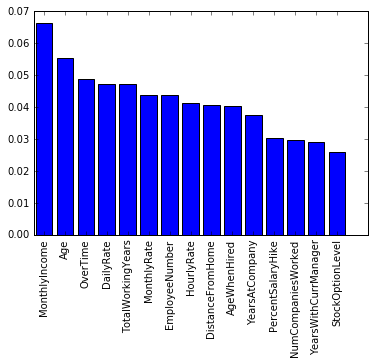

In [13]:
# execute the feature importance  on the dataset
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X, y)
k = 15
importances = clf.feature_importances_
sorted_indices = importances.argsort()[::-1][:k]
pos = np.arange(sorted_indices.shape[0]) + 0.5
plt.bar(pos, importances[sorted_indices], align='center')
plt.xticks(pos, X.columns[sorted_indices], rotation='vertical')

In [14]:
# look at the feaure importance in sorted order for each of them
d = dict( zip(X.columns, clf.feature_importances_) ) 
sorted(d.items(), key=lambda x: x[1])[::-1][:k]

[('MonthlyIncome', 0.066309386934787898),
 ('Age', 0.055364565304153117),
 ('OverTime', 0.048804100272267385),
 ('DailyRate', 0.047317677692979752),
 ('TotalWorkingYears', 0.047107986473833269),
 ('MonthlyRate', 0.043849857212546479),
 ('EmployeeNumber', 0.043716514698057318),
 ('HourlyRate', 0.041276408299507364),
 ('DistanceFromHome', 0.040490897307653526),
 ('AgeWhenHired', 0.040191184379898853),
 ('YearsAtCompany', 0.037403755009518577),
 ('PercentSalaryHike', 0.030308852168872684),
 ('NumCompaniesWorked', 0.029711101180924161),
 ('YearsWithCurrManager', 0.02899711920317068),
 ('StockOptionLevel', 0.025827549305191742)]